In [1]:
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
named_colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

from sklearn.utils.linear_assignment_ import linear_assignment
from envs import mwm2D_task

%matplotlib inline

In [2]:
# 5
#actor_path = os.path.join('results', 'models', 'mwm2D', 'spg', 'siamese', '5a7a10a32807f11b7248df37', 'actor-epoch-5.pt')
# 9
#actor_path = os.path.join('results', 'models', 'mwm2D', 'spg', 'siamese', '5a7acabc2807f11b7248df53', 'actor-epoch-7.pt')
# 7 - perfect - RS 520; 5 - 1260
#actor_path = os.path.join('results', 'models', 'mwm2D', 'spg', 'siamese', '5a7a4d242807f11b7248df3e', 'actor-epoch-5.pt')
# 10
actor_path = os.path.join('results', 'models', 'mwm2D', 'spg', 'siamese', '20391', 'actor-epoch-17.pt')

N = 10

actor = torch.load(actor_path, map_location=lambda storage, loc: storage)
actor.use_cuda = False
actor = actor.cpu()

In [28]:
best_random_seed = 200
most_matches = 0
#for ii in range(1000,2000):
torch.manual_seed(1)
sample = torch.FloatTensor(4, N).uniform_(0, 1)
#print(sample)
#print('--')
# Compute optimal
x_ = sample.numpy()
# compute reward matrix C to maximize
C = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        C[i,j] = np.linalg.norm(x_[2:4, i] - x_[0:2, j], ord=2)   
mm = linear_assignment(-C)
weight = np.sum(C[mm[:,0], mm[:,1]])
#print(mm, weight)

g1 = torch.t(sample[0:2, :])
g2 = torch.t(sample[2:4, :])
sample = torch.cat([g1, g2], dim=0).unsqueeze(0)
#print(sample)
sample = torch.autograd.Variable(sample, volatile=True)

_, perm, _, _ = actor.forward(sample)

# # convert perm to a matching
# actor_mm = np.zeros((N,2))
# tmp = np.expand_dims(np.arange(N), 0)
# matches = 0
# for i in range(N):
#     actor_mm[i,0] = i
#     for j in range(N):
#         if perm[:,j,i].data[0] == 1:
#             actor_mm[i,1] = j
#             if mm[i,1] == actor_mm[i,1]:
#                 matches += 1
# if matches > most_matches:
#     most_matches = matches
#     best_random_seed = ii
# print(most_matches, best_random_seed)

matchings = torch.matmul(torch.transpose(sample[:,N:2*N,:], 1, 2), perm)
matchings = torch.transpose(matchings, 1, 2)
matchings = torch.cat([sample[:,0:N,:], matchings], dim=1)

R = mwm2D_task.reward(matchings, False)
print(matchings, R, perm, R/weight)

Variable containing:
(0 ,.,.) = 
  0.4170  0.0923
  0.9972  0.3966
  0.7203  0.1863
  0.9326  0.3879
  0.0001  0.3456
  0.1281  0.6697
  0.3023  0.3968
  0.9990  0.9355
  0.1468  0.5388
  0.2361  0.8463
  0.3133  0.9140
  0.2045  0.5587
  0.4192  0.6705
  0.2296  0.9391
  0.5245  0.4572
  0.8781  0.1404
  0.5344  0.7784
  0.0274  0.1981
  0.6852  0.4173
  0.4435  0.4307
[torch.FloatTensor of size 1x20x2]
 Variable containing:
 7.2379
[torch.FloatTensor of size 1x1]
 Variable containing:
(0 ,.,.) = 
   0   0   1   0   0   0   0   0   0   0
   1   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   1   0
   0   0   0   0   1   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   1   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   0   0   0   0   1   0   0
   0   0   0   0   0   0   1   0   0   0
[torch.FloatTensor of size 1x10x10]
 Variable containing:
 0.9971
[torch.FloatTensor o

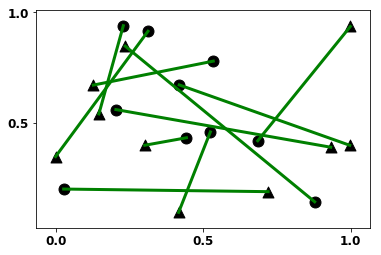

In [32]:
fig, ax = plt.subplots()
# Let's plot the original points
plt.scatter(x_[0,:], x_[1,:], c=named_colors['black'], marker='^', s=120)
plt.scatter(x_[2,:], x_[3,:], c=named_colors['black'], marker='o', s=120)

plt.xticks([0., 0.5, 1.], fontweight='bold')
plt.yticks([0., 0.5, 1.], fontweight='bold')
ax.tick_params(labelsize='large')
# Now connect them with optimal matching
xs_optimal = []
ys_optimal = []
for i in range(N):
    xs_optimal.append([x_[0,i], x_[2, mm[i,1]]])
    ys_optimal.append([x_[1,i], x_[3, mm[i,1]]])
    plt.plot(xs_optimal[-1], ys_optimal[-1], '-', c='g', linewidth=3)
plt.savefig('results/analysis/MWM_10_imgs/MWM_10_optimal_2301-torch-seed-1.png', dpi=300)

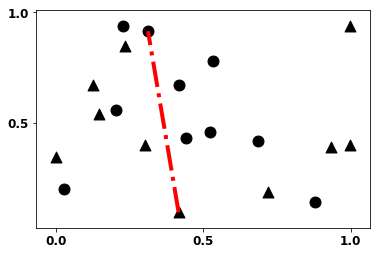

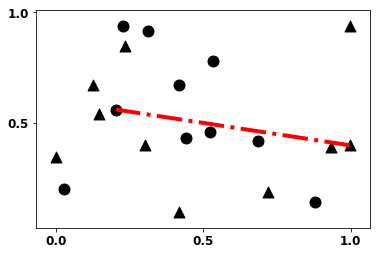

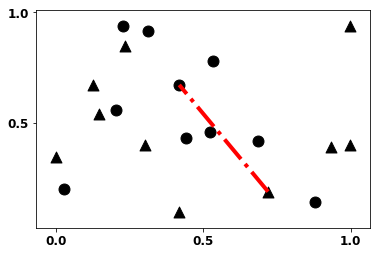

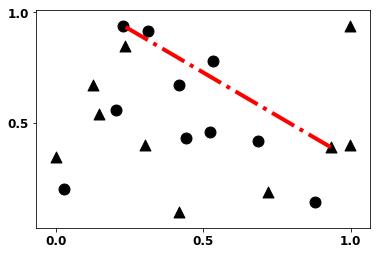

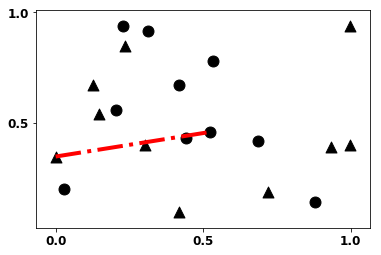

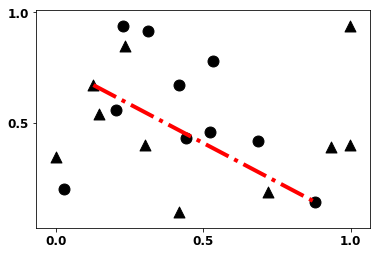

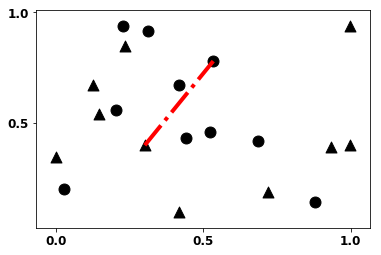

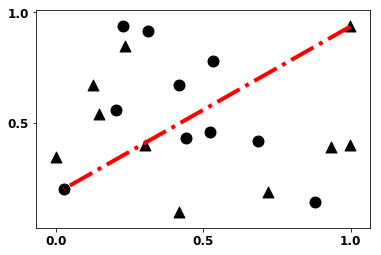

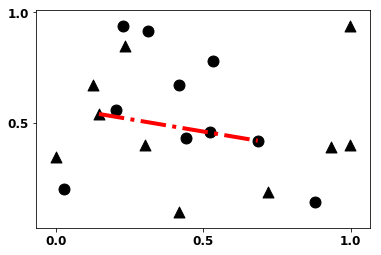

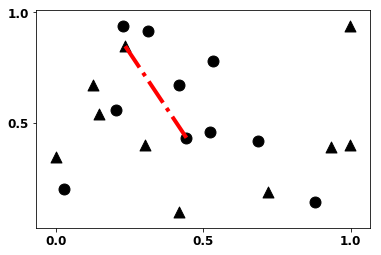

In [33]:
matchings = matchings.squeeze()
for i in range(N):
    fig, ax = plt.subplots()
    # Let's plot the original points
    plt.scatter(x_[0,:], x_[1,:], c=named_colors['black'], marker='^', s=120)
    plt.scatter(x_[2,:], x_[3,:], c=named_colors['black'], marker='o', s=120)
    plt.xticks([0., 0.5,  1.], fontweight='bold')
    plt.yticks([0., 0.5, 1.], fontweight='bold')
    ax.tick_params(labelsize='large')    
    xs = [matchings[i,0].data[0], matchings[i+N,0].data[0]]
    ys = [matchings[i,1].data[0], matchings[i+N,1].data[0]]
    if xs_optimal[i] == xs and ys_optimal[i] == ys:
        plt.plot(xs, ys, '-', c='g', linewidth=3)
    else:
        plt.plot(xs, ys, '-.', c='r', linewidth=4)
    fig.savefig('results/analysis/MWM_10_imgs/MWM_10_SPG_opt_ratio_0.9971-{}-torch-seed-1.png'.format(i), dpi=200)